# PCA tutorial for the python scientific environment

An extremely simple tutorial.  Most of the value is in doing the exercises.

### Contact us
Bradley Akitake, Mark Histed - code@histedlab.org


----
## Initialize this notebook - must run this cell before doing anything else

You will get a console window that allows you to type throw-away commands in without having to put them in a cell.
As of June 2016 (Jupyter 4.1.0, qtconsole 4.2.1), you will need to hit enter a few times in the console window to see a prompt.

In [2]:
%matplotlib inline

#load python modules
import matplotlib as mpl
import scipy.io as sio
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import sys
from __future__ import print_function # backward compat in case we are using python 2

#shortcuts for commonly used numpy features
a_ = np.asarray
r_ = np.r_

%qtconsole  # start a console window

# this does seem to work on Python 2 for now, so leave the below
#if not sys.version_info.major == 3:
#    raise RuntimeError('Cannot use this notebook on Python 2')

---------
# First, look at the waveform data so we can get a sense of what PCA will do


## 1) Load data, display some of it

In [5]:
# load data from matlab file
mat_contents = sio.loadmat('WaveformData/wfData-wire0.mat')
print(mat_contents)
unitWfArr = mat_contents['wfMat']
wfTsS = mat_contents['wfTs']

# we know the data is sampled at around 30kHz, so create a timept label vector
(nWfTimepts, nWfs) = np.shape(unitWfArr)
timeptMs = np.r_[0:nWfTimepts] / 30000.0 * 1000.0# load data

# Below: output of print statements above

{'__version__': '1.0', '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jul 23 13:47:02 2013', '__globals__': [], 'wfUnitN': array([[0, 3, 0, ..., 3, 3, 2]], dtype=uint8), 'wfTs': array([[  7.86666667e-03,   3.48000000e-02,   6.72000000e-02, ...,
          7.25167187e+03,   7.25168730e+03,   7.25172890e+03]]), 'pow2Ix': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'pow1Ix': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'noiseStd': array([[ 14.91224382]]), 'wfMat': array([[ 10,   7,  10, ..., -13,   7,   7],
       [ -3,   9,  10, ...,  -8,  -2,  -2],
       [-14,  10,   6, ...,  -3,   4,  -5],
       ..., 
       [-10,  -3, -15, ...,   8,  -1,  20],
       [-11,  -8,  -5, ...,  -9,  -6,  13],
       [-20,   1,  -8, ..., -10,  -4,  13]], dtype=int16), 'wireN': array([[1]], dtype=uint8)}


### Waveform data variable definitions
- **unitWfArr** is a matrix of shape (nWfTimepoints, nWfs)
  - Here those lengths are: 48 timepoints, 395k waveforms (recorded over two hours or so)
- **wfTsS** is a vector (len nWfs) that labels the start time of each of the 395k waveforms. 
  - Each value of wfTsV is a timestamp in seconds
- **timeptMs** is a vector (len nWfTimepoints) that labels the time of each sample within the waveform in ms

### Plot the waveform timestamps for the first 100 waveforms. 

(48, 395156)
(1, 395156)
7251.7289


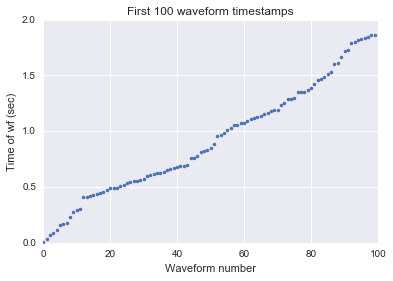

In [6]:
# show sizes/shapes of the loaded data
print(np.shape(unitWfArr))

print(np.shape(wfTsS))
print(np.max(wfTsS))

# example plot of waveform timestamps
plt.plot(wfTsS[0,0:100], '.')
plt.title('First 100 waveform timestamps')
plt.xlabel('Waveform number')
plt.ylabel('Time of wf (sec)')


## Plot some example waveforms and the mean

The Y-axes of waveforms are in arbitrary units - ADC (sample) units -- which we could convert to mV.

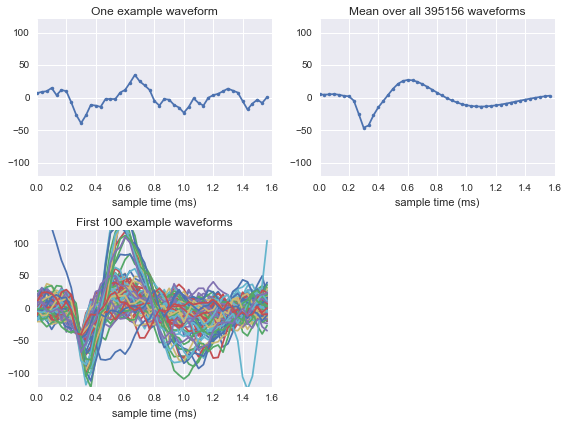

In [7]:
gs = mpl.gridspec.GridSpec(2,2)  # set up the multi-panel plot
figH = plt.figure(figsize=8*a_((1,0.75)))  # make figure, using a slightly larger size
yLims = 120*a_([-1,1])   # hardcode ylim value for all plots

#Plot a single waveform
axH = plt.subplot(gs[0,0])  # create axes for the first plot, using gridspec indexing
plt.plot(timeptMs, unitWfArr[:,1], '.-')
plt.xlabel('sample time (ms)')
plt.ylim(yLims)
plt.title('One example waveform')

#Plot the average of all waveforms
axH = plt.subplot(gs[0,1])  # second plot, new index in gridspec array
plt.plot(timeptMs, np.mean(unitWfArr, axis=1), '.-')
plt.xlabel('sample time (ms)')
plt.ylim(yLims)
plt.title('Mean over all %d waveforms' % nWfs)

#Plot overlay of first 100 waveforms
axH = plt.subplot(gs[1,0])  # 3rd plot
plt.plot(timeptMs, unitWfArr[:,0:100])
plt.xlabel('sample time (ms)')
plt.ylim(yLims)
plt.title('First 100 example waveforms')

plt.tight_layout()  # move plots around to prevent any label overlap

#### Notes from above plot
- you can see that the mean waveform is small, but there are a few large waveforms

------------

## 1. Exercise (viewing data)

1. Create a two-panel figure that shows waveforms 1000-1100 and the mean of waveforms 1000-1100
2. Bonus points: add 3rd panel to the figure that shows the standard deviation across waveforms.  It should plot twice the standard deviation above and below the mean waveform at each timepoint.  

**Example std dev plots, on other kinds of data **
<table><tr><td>This is one way to plot std devs/variance/errorbars<br><br>
<img src="files/img/chess-number-ply-over-time.png" width=300></td>
<td>This is a second way to plot them<br><br><img src="files/img/publication_grad_plot_with_python.png" width=300></td>
</tr></table>

In [ ]:
# add your exercise code here

-----
### Now we have plotted all the raw data, move on to PCA

------

# PCA demo 



## Run the PCA analysis.  What is PCA?  Generating a covariance matrix and diagonalizing it

- To show the PCA result, we plot projections back onto the first 2 eigenvectors

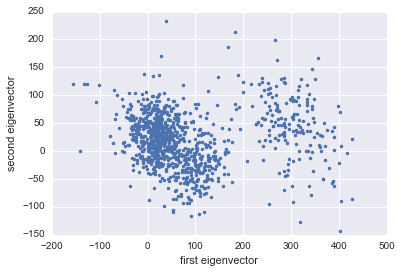

In [9]:
# remove mean
unitWfArrZM = unitWfArr - np.mean(unitWfArr, axis=1, keepdims=True) # keepdims: preserve broadcasting
# compute covariance matrix
covM = np.cov(unitWfArrZM[:,0:200000]) # compute over a subset of waveforms to save memory
# diagonalize cov matrix (compute eigenvalues and right eigenvectors of a square array)
(eigVal, eigVect) = np.linalg.eig(covM)
# project back onto first two eigenvectors (dot product of two arrays)
d0=np.dot(unitWfArr.T, eigVect[:,0:4])

desNs = r_[0:1000]
plt.plot(d0[desNs,0], d0[desNs,1], '.')
plt.xlabel('first eigenvector')
plt.ylabel('second eigenvector')

## What is PCA doing?  Generating eigenvalues and eigenvectors in descending order of captured data variance.  Below: explore those eigenvectors

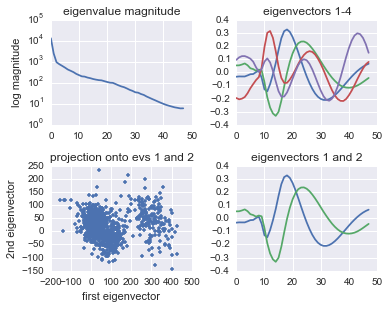

In [21]:
# To get a sense of what those eigenvectors look like, 
# make a figure projecting the data onto different eigenvector pairs

gs = mpl.gridspec.GridSpec(3,3)  # set up the multi-panel plot
fig = plt.figure(figsize=8*a_((1,0.75)))  # make figure, using a slightly larger size

#Plot eigenvalues
ax = plt.subplot(gs[0,0])
plt.plot(eigVal)
plt.yscale('log')
plt.ylabel('log magnitude')
plt.title('eigenvalue magnitude')

#Plot eigenvectors
ax = plt.subplot(gs[0,1])
plt.plot(eigVect[:,0:4])     # vectors 1 thru 4
plt.title('eigenvectors 1-4')
 
#Plot eigenvectors 1 and 2
ax = plt.subplot(gs[1,1])
plt.plot(eigVect[:,0:2])     # vectors 1 and 2
plt.title('eigenvectors 1 and 2')

#Plot in ev space
ax = plt.subplot(gs[1,0]) 
plt.plot(d0[desNs,0], d0[desNs,1], '.')
plt.xlabel('first eigenvector')
plt.ylabel('2nd eigenvector')
plt.title('projection onto evs 1 and 2')


plt.tight_layout()  # move plots around to prevent any label overlap

---
## 2. Exercise (PCA)

1. Other eigenvectors.
  1. Plot the first and third eigenvector
  2. Plot the projection onto the 1st and 3d eigenvector
  3. Compare it to the 1st and second eigenvector.  Is the 3rd eigenvector useful?  What does it tell us?  Write a bit of text answering these questions.  You may learn more about this by looking at the waveforms (below)
  4. Do the same for the fourth eigenvector

1. Extract waveforms based on clusters.
  1. define the center of the clusters in the projection onto evs 1 and 2.  There are two clusters.
  2. pull out 10 or so waveforms near the center of each of the two clusters.
  3. plot the 10 waveforms from each cluster.
  4. plot the mean of those waveforms, w/ errorbars given by $2 \cdot \sigma$ (standard deviation).
  5. Interpret the clusters by writing some text - what have we learned by working with projections onto two eigenvectors?  How do the waveforms cluster?  How do the clusters relate to the eigenvectors you plotted?  What features of the data are captured by which eigenvectors?  What value do the first and second eigenvectors have for sorting waveforms into clusters?




In [10]:
# add your exercise code here.  Use more cells if necessary.